In [103]:
import math

import numpy
import numpy as np
import matplotlib.pyplot as plt

EPS = 1e-6
ERR_EPS = 1.3e1
GRAD_ERR = 1e3
MAX_EPOCH = 10

plt.rcParams["figure.figsize"] = (20, 10)


def distance(x, y):
    return np.linalg.norm(x - y)


def abstract_descent_by_dir(first_point: np.matrix, next_point_fun: callable, stop_criteria: callable, callback=None):
    if not callback:
        callback = lambda ig, nore: None
    points = np.array([first_point])
    current_point = first_point
    epoch = 0
    while not stop_criteria(current_point) and epoch < MAX_EPOCH:
        next_point = next_point_fun(current_point)
        points = np.append(points, [next_point], axis=0)
        callback(current_point, next_point)
        current_point = np.copy(next_point)
        epoch += 1
    return points


# c, r - circle with center in c and radius r
# a, b - two points, b is further from c
# intersects circle with segment (a, b)
def cross(c, r, a, b):
    if distance(c, b) < r:
        return b
    if distance(c, a) > r:
        return (a - c) * r / distance(c, a)
    u = (b - a) / distance(b, a)
    delta = (u @ (a - c)) ** 2 - (distance(a, c) ** 2 - r ** 2)
    if delta < 0:
        raise "No intersection"
    d = -(u @ (a - c)) + numpy.sqrt(delta)
    return a + d * u



In [104]:
# p = (x_i, y_i) - observations
# f(p) = sum(r_i(p) ^ 2) -> min
# r_i = g(x_i, p) - y_i
class NonlinearRegression:
    def __init__(self, points_array, f: callable, grad):
        def r(x, y):
            return lambda p: (f(x, p) - y)

        self.r = [r(x, y) for (x, y) in points_array]
        self.j = [grad(x) for (x, _) in points_array]

    def get_r_at_p(self, p):
        return np.array([ri(p) for ri in self.r])

    def get_j_at_p(self, p):
        return np.array([[jij(p) for jij in ji] for ji in self.j])

    def get_grad_at_p(self, p):
        r = self.get_r_at_p(p)
        j = self.get_j_at_p(p)
        return 2 * j.transpose() @ r

    def get_h_at_p(self, p):
        j = self.get_j_at_p(p)
        return 2 * j.transpose() @ j

    def at_p(self, p):
        return np.sum([ri(p) ** 2 for ri in self.r])

    def error_stop(self, p):
        return self.at_p(p) < ERR_EPS

    def grad_stop(self, p):
        return np.linalg.norm(self.get_grad_at_p(p)) < GRAD_ERR

    def gauss_newton(self, first_point):
        def next_point(prev):
            r = self.get_r_at_p(prev)
            j = self.get_j_at_p(prev)
            # p = np.linalg.inv(j.transpose() @ j) @ j.transpose() @ r
            p = np.linalg.solve(j.transpose() @ j, j.transpose() @ r)
            return prev - 1 * p

        prev = None

        def stop_criteria(x):
            nonlocal prev
            if prev is None:
                to_return = False
            else:
                to_return = distance(prev, x) < EPS
            prev = x
            return to_return

        return abstract_descent_by_dir(first_point, next_point, stop_criteria)
        # return abstract_descent_by_dir(first_point, next_point, self.error_stop)

    def dogleg(self, first_point, max_trust_reg=100, rho_bound=0.25):
        max_delta = max_trust_reg
        delta = max_delta

        def update_delta(curr, prev):
            nonlocal delta
            grad_f = self.get_grad_at_p(curr)
            h = self.get_h_at_p(curr)
            m_p = self.at_p(curr) + grad_f.transpose() @ prev + 0.5 * prev.transpose() @ h @ prev
            f_x = self.at_p(curr)
            f_xp = self.at_p(curr + prev)
            rho = (f_x - f_xp) / (f_x - m_p)
            if rho < rho_bound:
                delta = delta / 4
            elif rho > 1 - rho_bound and math.isclose(distance(curr, prev), delta):
                delta = min(2 * delta, max_delta)

        def next_point(prev):
            grad_f = self.get_grad_at_p(prev)
            h = self.get_h_at_p(prev)

            a_divisible = grad_f.transpose() @ grad_f
            a_divider = grad_f.transpose() @ h @ grad_f

            a = -(a_divisible / a_divider) * grad_f
            b = -np.linalg.solve(h, grad_f)
            return prev + cross(prev, delta, a, b)

        prev = None

        def stop_criteria(x):
            nonlocal prev
            if prev is None:
                to_return = False
            else:
                to_return = distance(prev, x) < EPS
            prev = x
            return to_return

        return abstract_descent_by_dir(first_point, next_point, stop_criteria, update_delta)
        # return abstract_descent_by_dir(first_point, next_point, self.error_stop, update_delta)

    def bfgs(self, first_point):
        x = np.array(first_point)
        at_x = self.at_p(x)
        grad = self.get_grad_at_p(x)

        i = np.zeros((x.size, x.size))
        np.fill_diagonal(i, 1)
        h = np.copy(i)

        delta = 0.0002
        c1 = 1e-4
        c2 = 0.9

        def next_point(x):
            p = 0.1 * h @ grad

            def f(alpha):
                return self.at_p(x - alpha * p)


            def dichotomy(f):
                left = -1
                right = 1
                x = left
                while right - left >= EPS:
                    x = (left + right) / 2
                    if f(x - delta) <= f(x + delta):
                        right = x
                    else:
                        left = x
                return x

            alpha = dichotomy(f)
            return x - alpha * p

        def recalc(_, new_point):
            nonlocal x, at_x, grad, h

            new_grad = self.get_grad_at_p(new_point)
            s = new_point - x
            y = new_grad - grad

            # b = b - (b @ s @ s.transpose() @ b.transpose()) / (s.transpose() @ b @ s) \
            #     + (y * y.transpose()) / (y.transpose() @ s)
            rho = 0.1 / (y.transpose() @ s)
            h = (i - rho * s @ y.transpose()) @ h @ (i - rho * y @ s.transpose()) + rho * s @ s.transpose()
            x = new_point
            at_x = self.at_p(x)
            grad = new_grad

        prev = None

        def stop_criteria(x):
            nonlocal prev
            if prev is None:
                to_return = False
            else:
                to_return = distance(prev, x) < EPS
            prev = x
            return to_return

        return abstract_descent_by_dir(first_point, next_point, self.grad_stop, recalc)
        # return abstract_descent_by_dir(first_point, next_point, stop_criteria, recalc)

In [105]:
def make_sample(f, number_of_point, bounds, error):
    def noise(y): return y * (1 + np.random.uniform(-error, error))

    (l, r) = bounds
    x = np.random.uniform(l, r, number_of_point)
    return [(xi, noise(f(xi))) for xi in x]


def test_method(reg, method, first_point):
    if method == "gn":
        return reg.gauss_newton(first_point)
    elif method == "dogleg":
        return reg.dogleg(first_point)
    elif method == "bfgs":
        return reg.bfgs(first_point)
    else:
        raise "Unknown method"


def abstract_test(init_params, first_point, fun, grad, sample_size=100, bounds=(1, 10), error=0.1):
    def init_fun(x): return fun(x, init_params)

    sample = make_sample(init_fun, sample_size, bounds, error)

    methods = (("gn", "green"), ("dogleg", "orange"), ("bfgs", "red"))

    reg = NonlinearRegression(sample, fun, grad)

    fig = plt.figure()
    fig.set_size_inches(10, 10)

    def draw_graph(f, color='blue'):
        x = np.linspace(bounds[0], bounds[1], sample_size)
        y = np.array([f(i) for i in x])
        plt.plot(x, y, color=color)

    plt.scatter([elem[0] for elem in sample], [elem[1] for elem in sample])
    draw_graph(init_fun, color='blue')

    print("Testing parameters:", init_params)
    print("First point:", first_point)
    print("Sample error:", error)
    print("Error at init params:", reg.at_p(init_params))
    print("Error at first point:", reg.at_p(first_point))
    for (method, color) in methods:
        print("\tTesting", method, ":")
        steps = test_method(reg, method, first_point)
        result = steps[-1]
        print("\t\tSteps:", steps.size)
        # print(steps)
        print("\t\tParams found:", result)
        def f(x): return fun(x, result)
        draw_graph(f, color=color)
        print("\t\tError:", reg.at_p(result))
    plt.show()


def multitest(init_params, first_point, fun, grad, sample_size):
    abstract_test(init_params, first_point, fun, grad, sample_size, error=0.05)
    print()
    abstract_test(init_params, first_point, fun, grad, sample_size, error=0.2)

def test_parabola(params, first_point, sample_size=100):
    init_params = np.array(params)

    def fun(x, p):
        [a, b, c] = p
        return a * (x ** 2) + b * x + c

    def grad(x):
        return np.array([lambda _: x ** 2,
                         lambda _: x,
                         lambda _: 1])
    multitest(init_params, first_point, fun, grad, sample_size)


def test_exp(params, first_point, sample_size=100):
    init_params = np.array(params)

    def fun(x, p):
        [a, b] = p
        return a * np.exp(b * x)

    def grad(x):
        return np.array([lambda p: np.exp(p[1] * x),
                         lambda p: p[0] * np.exp(p[1] * x) * x])

    multitest(init_params, first_point, fun, grad, sample_size)


def test_sin(params, first_point, sample_size=100):
    init_params = np.array(params)

    def fun(x, p):
        [a, b] = p
        return a * np.sin(b * x)

    def grad(x):
        return np.array([lambda p: np.sin(p[1] * x),
                         lambda p: p[0] * np.cos(p[1] * x) * x])

    multitest(init_params, first_point, fun, grad, sample_size)



Testing parameters: [10 20 30]
First point: [5, 10, 15]
Sample error: 0.05
Error at init params: 31405.683100584898
Error at first point: 8404227.395218344
	Testing gn :
		Steps: 9
		Params found: [ 9.66354596 22.63718896 25.87207326]
		Error: 30101.25843278045
	Testing dogleg :
		Steps: 9
		Params found: [ 9.66354596 22.63718896 25.87207326]
		Error: 30101.25843278045
	Testing bfgs :
		Steps: 33
		Params found: [11.30688955 11.24575752 14.99465067]
		Error: 84171.94195036947


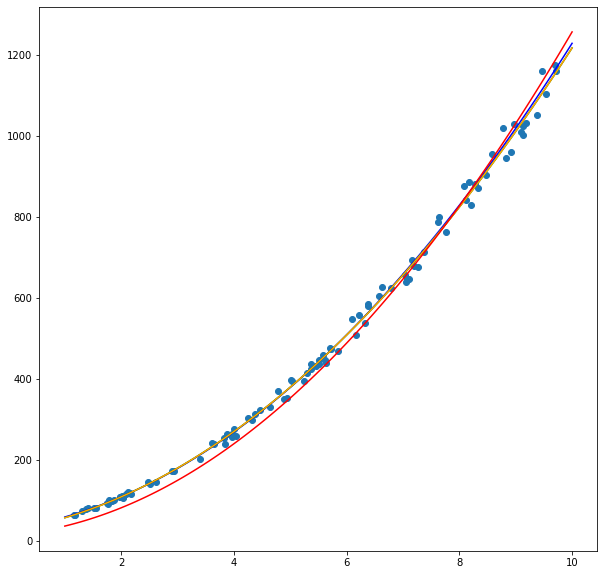


Testing parameters: [10 20 30]
First point: [5, 10, 15]
Sample error: 0.2
Error at init params: 463341.586764674
Error at first point: 10443209.118822942
	Testing gn :
		Steps: 9
		Params found: [ 9.03168257 28.90543287 16.48314171]
		Error: 457650.7380172053
	Testing dogleg :
		Steps: 9
		Params found: [ 9.03168257 28.90543287 16.48314171]
		Error: 457650.7380172053
	Testing bfgs :
		Steps: 33
		Params found: [10.48764599 17.60706006 13.92192854]
		Error: 491623.9848324466


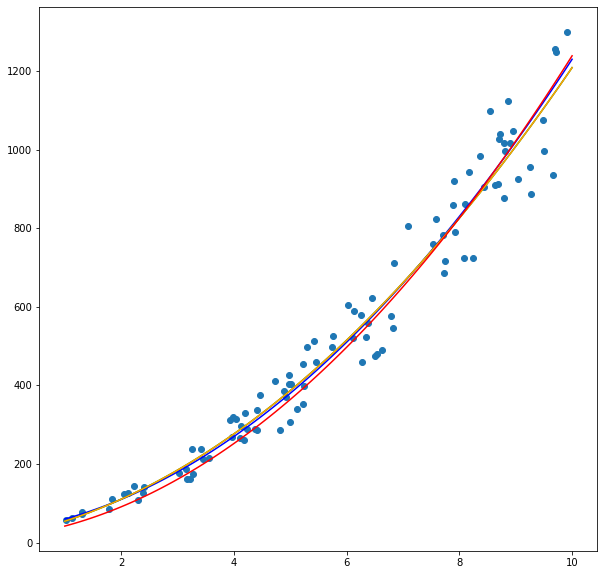

In [107]:
test_parabola([10, 20, 30], [5, 10, 15], sample_size=100)
# test_exp([5, 1], [5, 1], sample_size=100)
# print(test_sin(2, 1, sample_size=100))